In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
train = pd.read_csv("data/train.csv")
top1 = train[train.item_nbr == 265559 ]
top1['date'] = pd.to_datetime(top1['date'])
top1['year'] = top1['date'].dt.year

C:\Users\anzel\AppData\Local\Temp\ipykernel_17124\1407331671.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("data/train.csv")
C:\Users\anzel\AppData\Local\Temp\ipykernel_17124\1407331671.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top1['date'] = pd.to_datetime(top1['date'])
C:\Users\anzel\AppData\Local\Temp\ipykernel_17124\1407331671.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top1['year'] = top1['date'].dt.year

#### Подготовим данные

In [3]:
unit_sales_by_date = top1.groupby('date').sum()['unit_sales']

#### Импортируем метрики

In [4]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

ModuleNotFoundError: No module named 'sklearn'

### Тест Адфуллера для проверки стационарных временных рядов

In [6]:
from statsmodels.tsa.stattools import adfuller

X = unit_sales_by_date.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -6.447066
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Reject Ho - Time Series is Stationary


Ряд - стационарный. Если бы ряд был нестационарным, нам необходимо было бы продифференцировать ряд до тех пор, пока бы мы не получили стационарный ряд. Количество дифференцирований будет опреледелять пораметр d в модели ARIMA. В нашем случае d=0, так как к дифференцированию мы не прибегали.

Отложим тестовую выборку: последние 7 дней.

## Модель скользящего среднего

Реализуем модель скользящего среднего. За окно попробуем взять 7 дней(неделя). После чего сравним результат с последними 7 днями, которые не использовали в рассчете скользящего среднего. Вы можете сравнить результат с другим размером окна.

(7,) (7,)
mean_squared_error 174007.24781341106
mean_absolute_error 331.469387755102


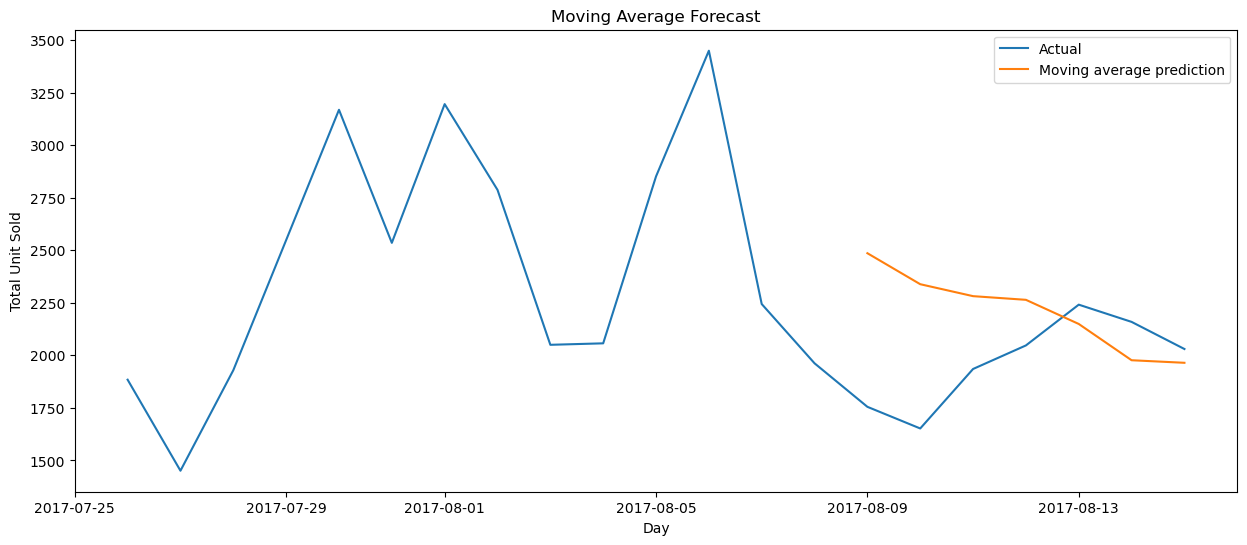

In [22]:


def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)
moving_average_days = 7

shown_train_size = moving_average_days * 3
moving_avg = moving_average_forecast(unit_sales_by_date,moving_average_days )
moving_avg = pd.Series(moving_avg, index = unit_sales_by_date[moving_average_days:].index)

print(moving_avg[-moving_average_days:].shape,unit_sales_by_date[-moving_average_days:].shape)

print("mean_squared_error",mean_squared_error(unit_sales_by_date.values[-moving_average_days:], moving_avg[-moving_average_days:]))
print("mean_absolute_error",mean_absolute_error(unit_sales_by_date.values[-moving_average_days:], moving_avg[-moving_average_days:]))

plt.figure(figsize=(15,6))

plt.plot(unit_sales_by_date[- shown_train_size:], label="Actual")
plt.plot(moving_avg[-moving_average_days:], label="Moving average prediction")
plt.ylabel("Total Unit Sold")
plt.xlabel("Day")
plt.title("Moving Average Forecast")
plt.legend(loc="upper right")
plt.show()

Теперь сравним результат с линейной регрессией. Так как такая модель позволяет использовать дополнительные признаки, а предсказание будет на 7 дней - мы модем добавить лаги, начиная от 7. Возьмем несколько

[ 0.2970627   0.11733797 -0.09552626 -0.09312254  0.03953392 -0.10282257
  0.19819843]
1564.8066053473433
mean_squared_error 253811.58978581772
mean_absolute_error 469.91277076681536


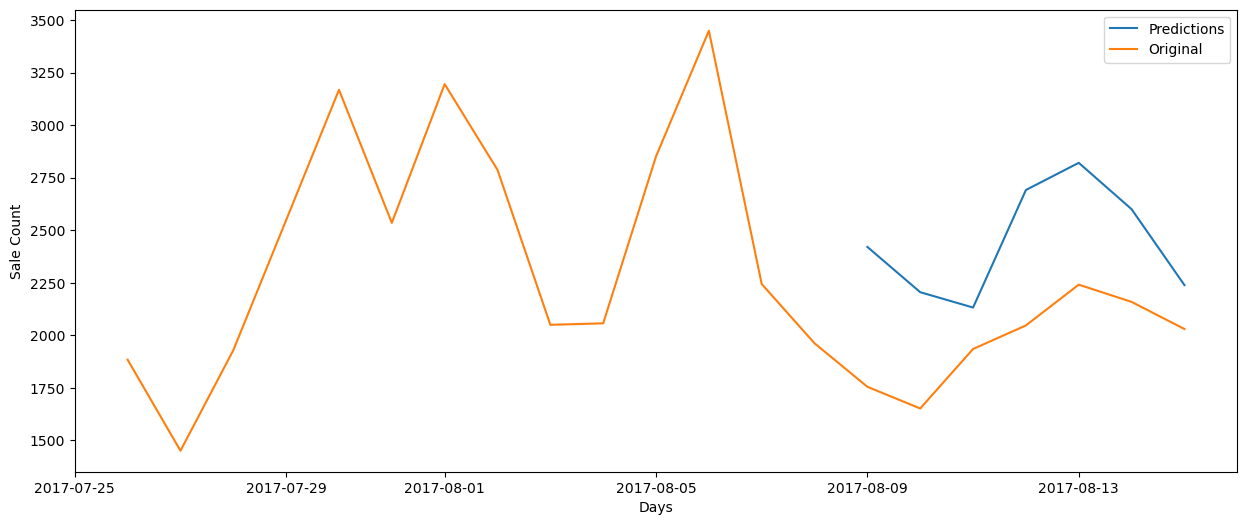

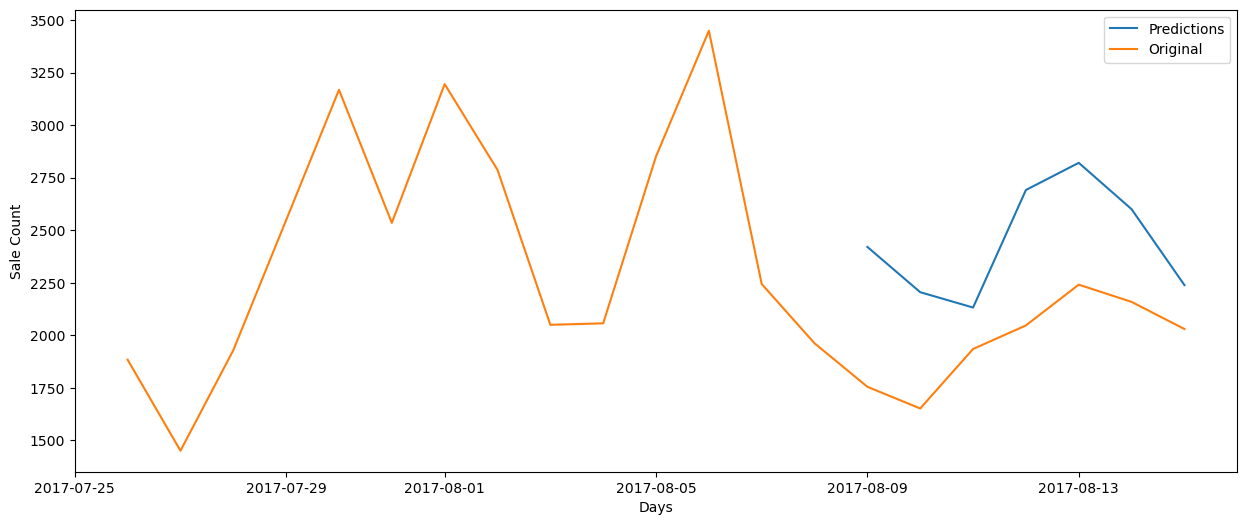

In [11]:
predict_size = 7
df = pd.DataFrame()

df["Original Values"]  = unit_sales_by_date
df["shift7"] = df["Original Values"].shift(7)
df["shift8"] = df["shift7"].shift()
df["shift9"] = df["shift8"].shift()
df["shift10"] = df["shift9"].shift()
df["shift11"] = df["shift10"].shift()
df["shift12"] = df["shift11"].shift()
df["shift13"] = df["shift12"].shift()
df.dropna(inplace=True)

x_train, y_train = df[:-predict_size].drop(["Original Values"], axis =1), df[:-predict_size]["Original Values"]
x_test, y_test  = df[-predict_size:].drop(["Original Values"], axis =1), df[-predict_size:]["Original Values"]


from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)
print(reg.coef_)
print(reg.intercept_)


ar_predictions = pd.Series(reg.predict(x_test), index=x_test.index)

plt.figure(figsize=(15,6))
plt.plot(ar_predictions ,label = "Predictions")
plt.plot(pd.concat([y_train, y_test], axis = 0)[-shown_train_size:], label = "Original" )
plt.xlabel("Days")
plt.ylabel("Sale Count")

print("mean_squared_error",mean_squared_error(y_test, ar_predictions))
print("mean_absolute_error",mean_absolute_error(y_test, ar_predictions))


plt.legend(loc="upper right")
plt.show()

Качество этой модели хуже предыдущей, но мы видмс, что эта модель неплохо предсказывает тенденцию, так как силуэты графиков схожи.

Итак, чтобы построить ARIMA модель нам нужно знать ее порядок, состоящий из 3-х параметров:
    
    p — порядок компоненты AR
    d — порядок интегрированного ряда
    q — порядок компонетны MA
    
d мы уже знаем - это 0

осталось определить p и q. Для их определения нам надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.

ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.

Чтобы построить соответствующие коррелограммы, в пакете statsmodels имеются следующие функции: plot_acf() и plot_pacf(). Они выводят графики ACF и PACF, у которых по оси X откладываются номера лагов, а по оси Y значения соответствующих функций. Нужно отметить, что количество лагов в функциях и определяет число значимых коэффициентов.

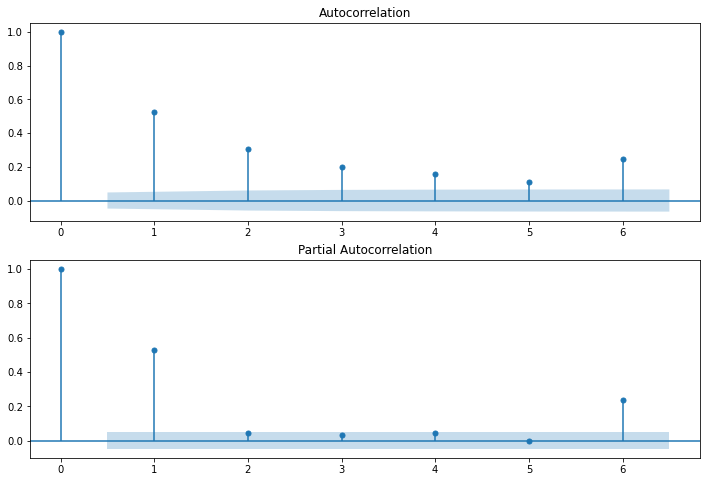

In [13]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(unit_sales_by_date.values.squeeze(), lags=6, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(unit_sales_by_date, lags=6, ax=ax2)

После изучения коррелограммы PACF можно сделать вывод, что p = 6, т.к. на ней все лаги сильно отличны от нуля.
По коррелограмме ACF можно предположить, что q = 6, т.к. на лаг 6 значении функций резко возрастает. Итак, когда известны все параметры можно построить модель.

## ARIMA model

In [12]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y_train.values.reshape(-1), order=(6,0,6))

In [13]:
from statsmodels.graphics.tsaplots import plot_predict

train_size = len(y_train)
test_size = predict_size
arima_predictions = model.fit().predict(start=train_size,end=train_size+test_size -1,  dynamic=False)

plt.plot(pd.Series(arima_predictions, index=y_test.index) ,label = "Predictions")
plt.plot(pd.concat([y_train, y_test], axis = 0)[-shown_train_size:], label = "Original" )
plt.legend(loc="upper right")

c:\Users\anzel\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\anzel\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
print("mean_squared_error",mean_squared_error(y_test, arima_predictions))
print("mean_absolute_error",mean_absolute_error(y_test, arima_predictions))


mean_squared_error 172900.2097763731
mean_absolute_error 377.27812653081935
